# Testing Keras Model on 3JHH
- Use the features created within folds in tabular Model M056

In [1]:
import pandas as pd
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import os
import gc
#%cd /kaggle/input/champs-scalar-coupling
#print(os.listdir("."))
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
def plot_history(history, label):
    plt.plot(history.history['loss'][-100:])
    plt.plot(history.history['val_loss'][-100:])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [4]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

start_time=datetime.now()

In [5]:
mol_type = '3JHH'

## Read data and concat

In [6]:
# Read input for first fold
X_train = pd.read_parquet('../type_results/3JHH/meta/M053_0725_0821_3JHH_X_train_meta_fc_f1_0.1753MAE_-1.7413LMAE.parquet') 
X_test = pd.read_parquet('../type_results/3JHH/meta/M053_0725_0821_3JHH_X_test_meta_fc_f1_0.1753MAE_-1.7413LMAE.parquet')
X_valid = pd.read_parquet('../type_results/3JHH/meta/M053_0725_0821_3JHH_X_valid_meta_fc_f1_0.1753MAE_-1.7413LMAE.parquet')
X_train['split'] = 'TRAIN'
X_test['split'] = 'TEST'
X_valid['split'] = 'VALID'

# Add target to train and val
train = pd.read_csv('../input/train.csv')
X_tr_val = pd.concat([X_train, X_valid])
X_tr_val = X_tr_val.sort_index()
X_tr_val['scalar_coupling_constant'] = train.loc[train['type'] == '3JHH']['scalar_coupling_constant'].tolist()
X_tr_val['molecule_name'] = train.loc[train['type'] == '3JHH']['molecule_name'].tolist()
X_tr_val['atom_index_0'] = train.loc[train['type'] == '3JHH']['atom_index_0'].tolist()
X_tr_val['atom_index_1'] = train.loc[train['type'] == '3JHH']['atom_index_1'].tolist()

# Combine all
X_all = pd.concat([X_tr_val, X_test])

In [7]:
X_all.shape

(908046, 386)

## Add target features

In [8]:
def map_atom_info(df_1,df_2, atom_idx):
    print('Mapping...', df_1.shape, df_2.shape, atom_idx)
    df = pd.merge(df_1, df_2.drop_duplicates(subset=['molecule_name', 'atom_index']), how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df

In [9]:
df_struct=pd.read_csv('../input/structures.csv')
df_train_sub_charge=pd.read_csv('../input/mulliken_charges.csv')
df_train_sub_tensor=pd.read_csv('../input/magnetic_shielding_tensors.csv')

In [10]:
for atom_idx in [0,1]:
    X_all = map_atom_info(X_all,df_struct, atom_idx)
    X_all = map_atom_info(X_all,df_train_sub_charge, atom_idx)
    X_all = map_atom_info(X_all,df_train_sub_tensor, atom_idx)
    X_all = X_all.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'mulliken_charge': f'charge_{atom_idx}',
                                        'XX': f'XX_{atom_idx}',
                                        'YX': f'YX_{atom_idx}',
                                        'ZX': f'ZX_{atom_idx}',
                                        'XY': f'XY_{atom_idx}',
                                        'YY': f'YY_{atom_idx}',
                                        'ZY': f'ZY_{atom_idx}',
                                        'XZ': f'XZ_{atom_idx}',
                                        'YZ': f'YZ_{atom_idx}',
                                        'ZZ': f'ZZ_{atom_idx}',})

Mapping... (908046, 386) (2358657, 6) 0
Mapping... (908046, 390) (1533537, 3) 0
Mapping... (908046, 391) (1533537, 11) 0
Mapping... (908046, 400) (2358657, 6) 1
Mapping... (908046, 404) (1533537, 3) 1
Mapping... (908046, 405) (1533537, 11) 1


In [11]:
X_all.shape

(908046, 414)

In [12]:
ys_all = X_all[['scalar_coupling_constant',"charge_0","charge_1",
                "XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1","YX_0","ZX_0",
                "XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1",
                "XZ_1","YZ_1"]]
split_all = X_all['split']

In [13]:
X_all = X_all.drop(['scalar_coupling_constant',"charge_0","charge_1",
                "XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1","YX_0","ZX_0",
                "XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1",
                "XZ_1","YZ_1"], axis=1)

## Normalize and fill NA

In [14]:
#Impute NA with mean
MEAN = X_all.mean()
X_all.fillna( value=MEAN, inplace=True )

In [15]:
splits = X_all['split']
target_all = ys_all['scalar_coupling_constant']
X_all = X_all.drop('split', axis=1)

In [16]:
X_all.get_dtype_counts()

float64    382
int64        7
object       3
dtype: int64

In [17]:
X_all.select_dtypes('object').head()

,molecule_name,atom_0,atom_1
0,dsgdb9nsd_000007,H,H
1,dsgdb9nsd_000007,H,H
2,dsgdb9nsd_000007,H,H
3,dsgdb9nsd_000007,H,H
4,dsgdb9nsd_000007,H,H


In [18]:
X_all = X_all.drop(['atom_0','atom_1','molecule_name'], axis=1)

In [19]:
X_all[X_all.columns] = StandardScaler().fit_transform(X_all[X_all.columns])

In [24]:
X_all.head()

,10th_closest_to_0_atomic_mass_x_cube_inv_dist,10th_closest_to_0_valence_x_cube_inv_dist,10th_closest_to_1_atomic_mass_x_cube_inv_dist,10th_closest_to_1_valence_x_cube_inv_dist,12th_closest_to_0_atomic_mass_x_cube_inv_dist,12th_closest_to_1_atomic_mass_x_cube_inv_dist,13th_closest_to_1_atomic_mass_x_cube_inv_dist,14th_closest_to_1_atomic_mass_x_cube_inv_dist,2nd_closest_to_0_atomic_mass,2nd_closest_to_0_atomic_mass_x_cube_inv_dist,...,yukawa_H.y,yukawa_N.x,yukawa_O.x,zpve,x_0,y_0,z_0,x_1,y_1,z_1
0,-1.452228e-16,0.0,4.293363e-16,-2.866255e-16,1.999476e-16,-1.961299e-16,-1.161487e-16,-1.391628e-16,-0.838369,-0.805796,...,0.885565,-0.523176,-0.806292,-2.991638,0.686321,1.172969,-0.004142,0.266366,0.175894,0.600348
1,-1.452228e-16,0.0,4.293363e-16,-2.866255e-16,1.999476e-16,-1.961299e-16,-1.161487e-16,-1.391628e-16,-0.838369,-0.805796,...,0.885556,-0.523176,-0.806292,-2.991638,0.686321,1.172969,-0.004142,-0.743947,0.166175,-0.060098
2,-1.452228e-16,0.0,4.293363e-16,-2.866255e-16,1.999476e-16,-1.961299e-16,-1.161487e-16,-1.391628e-16,-0.838369,-0.805796,...,0.885467,-0.523176,-0.806292,-2.991638,0.686321,1.172969,-0.004142,0.255283,0.181582,-0.742665
3,-1.452228e-16,0.0,4.293363e-16,-2.866255e-16,1.999476e-16,-1.961299e-16,-1.161487e-16,-1.391628e-16,-0.838369,-0.805796,...,0.885565,-0.523176,-0.806292,-2.991638,-0.427959,1.163556,-0.725801,0.266366,0.175894,0.600348
4,-1.452228e-16,0.0,4.293363e-16,-2.866255e-16,1.999476e-16,-1.961299e-16,-1.161487e-16,-1.391628e-16,-0.838369,-0.805796,...,0.885556,-0.523176,-0.806292,-2.991638,-0.427959,1.163556,-0.725801,-0.743947,0.166175,-0.060098


In [25]:
# Standard scale ys
ys_all.head()

,scalar_coupling_constant,charge_0,charge_1,XX_0,YY_0,ZZ_0,XX_1,YY_1,ZZ_1,YX_0,...,XY_0,ZY_0,XZ_0,YZ_0,YX_1,ZX_1,XY_1,ZY_1,XZ_1,YZ_1
0,-0.409776,0.090894,0.011320,0.596522,0.196306,0.504027,0.752920,-0.411926,1.064246,-1.184736,...,-0.942671,-1.206584,1.049580,-1.269152,-0.613028,-1.631937,-0.490785,0.679484,-1.281753,0.722900
1,2.407644,0.090894,0.011255,0.596522,0.196306,0.504027,0.752987,0.213327,0.512532,-1.184736,...,-0.942671,-1.206584,1.049580,-1.269152,-1.204542,1.314307,-0.956224,-1.119617,1.040778,-1.181487
2,-0.409981,0.090894,0.011320,0.596522,0.196306,0.504027,0.752920,1.281771,-0.430447,-1.184736,...,-0.942671,-1.206584,1.049580,-1.269152,1.801761,0.323357,1.409672,0.390512,0.259696,0.417099
3,2.407941,0.090971,0.011320,0.596489,-0.451417,1.086216,0.752920,-0.411926,1.064246,-0.605203,...,-0.477247,0.749744,-1.324566,0.787306,-0.613028,-1.631937,-0.490785,0.679484,-1.281753,0.722900
4,-0.409852,0.090971,0.011255,0.596489,-0.451417,1.086216,0.752987,0.213327,0.512532,-0.605203,...,-0.477247,0.749744,-1.324566,0.787306,-1.204542,1.314307,-0.956224,-1.119617,1.040778,-1.181487


In [22]:
ys_all[ys_all.columns] = StandardScaler().fit_transform(ys_all[ys_all.columns])

In [23]:
ys_all.head()

,scalar_coupling_constant,charge_0,charge_1,XX_0,YY_0,ZZ_0,XX_1,YY_1,ZZ_1,YX_0,...,XY_0,ZY_0,XZ_0,YZ_0,YX_1,ZX_1,XY_1,ZY_1,XZ_1,YZ_1
0,-0.409776,0.090894,0.011320,0.596522,0.196306,0.504027,0.752920,-0.411926,1.064246,-1.184736,...,-0.942671,-1.206584,1.049580,-1.269152,-0.613028,-1.631937,-0.490785,0.679484,-1.281753,0.722900
1,2.407644,0.090894,0.011255,0.596522,0.196306,0.504027,0.752987,0.213327,0.512532,-1.184736,...,-0.942671,-1.206584,1.049580,-1.269152,-1.204542,1.314307,-0.956224,-1.119617,1.040778,-1.181487
2,-0.409981,0.090894,0.011320,0.596522,0.196306,0.504027,0.752920,1.281771,-0.430447,-1.184736,...,-0.942671,-1.206584,1.049580,-1.269152,1.801761,0.323357,1.409672,0.390512,0.259696,0.417099
3,2.407941,0.090971,0.011320,0.596489,-0.451417,1.086216,0.752920,-0.411926,1.064246,-0.605203,...,-0.477247,0.749744,-1.324566,0.787306,-0.613028,-1.631937,-0.490785,0.679484,-1.281753,0.722900
4,-0.409852,0.090971,0.011255,0.596489,-0.451417,1.086216,0.752987,0.213327,0.512532,-0.605203,...,-0.477247,0.749744,-1.324566,0.787306,-1.204542,1.314307,-0.956224,-1.119617,1.040778,-1.181487


# Put in expected format

In [32]:
X_train = X_all.loc[splits == 'TRAIN']
X_valid = X_all.loc[splits == 'VALID']
X_test = X_all.loc[splits == 'TEST']

In [34]:
y_train = ys_all.loc[splits == 'TRAIN']
y_valid = ys_all.loc[splits == 'VALID']
y_test = ys_all.loc[splits == 'TEST']

In [ ]:
# X_tr_val['scalar_coupling_constant'][splits == 'TRAIN']

In [97]:
target_train = target_all[splits == 'TRAIN']
target_valid = target_all[splits == 'VALID']
target_test = target_all[splits == 'TEST']

In [115]:
m1=2
m2=4
m3=1

train_input=X_train.values
cv_input=X_valid.values
train_target=target_train.values
cv_target=target_valid.values
train_target_1=m1 * y_train[["charge_0","charge_1"]].values
cv_target_1=m1 * y_valid[["charge_0","charge_1"]].values
train_target_2=m2 * y_train[["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]].values
cv_target_2=m2 * y_valid[["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]].values
train_target_3=m3 * y_train[["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]].values
cv_target_3=m3 * y_valid[["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]].values
test_input=X_test.values

In [116]:
# df_train_ = df_train_case_final[ df_train_case_final["type"]==mol_type]
# df_test_  = df_test_case_final [ df_test_case_final["type"]==mol_type]

# # Here's our best features.  We think.
# input_features=extra_featus

# # Standard Scaler from sklearn does seem to work better here than other Scalers
# input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))

# target_data=df_train_.loc[:,"scalar_coupling_constant"].values
# target_data_1=df_train_.loc[:,["charge_0","charge_1"]]
# target_data_2=df_train_.loc[:,["XX_0","YY_0","ZZ_0","XX_1","YY_1","ZZ_1"]]
# target_data_3=df_train_.loc[:,["YX_0","ZX_0","XY_0","ZY_0","XZ_0","YZ_0","YX_1","ZX_1","XY_1","ZY_1","XZ_1","YZ_1"]]

# #following parameters should be adjusted to control the loss function
# #if all parameters are zero, attractors do not work. (-> simple neural network)
# m1=2
# m2=4
# m3=1
# target_data_1=m1*(StandardScaler().fit_transform(target_data_1))
# target_data_2=m2*(StandardScaler().fit_transform(target_data_2))
# target_data_3=m3*(StandardScaler().fit_transform(target_data_3))

# # Simple split to provide us a validation set to do our CV checks with
# #train_index, cv_index = train_test_split(np.arange(len(df_train_)),random_state=111, test_size=0.05)
# train_index = np.where(splits != 0)[0]
# cv_index = np.where(splits == 0)[0]

# # Split all our input and targets by train and cv indexes
# train_input=input_data[train_index]
# cv_input=input_data[cv_index]
# train_target=target_data[train_index]
# cv_target=target_data[cv_index]
# train_target_1=target_data_1[train_index]
# cv_target_1=target_data_1[cv_index]
# train_target_2=target_data_2[train_index]
# cv_target_2=target_data_2[cv_index]
# train_target_3=target_data_3[train_index]
# cv_target_3=target_data_3[cv_index]
# test_input=input_data[len(df_train_):,:]

## Create Model

In [117]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(1024)(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dropout(0.2)(x)
    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    out1 = Dense(2, activation="linear",name='outM2')(x)#mulliken charge 2
    out2 = Dense(6, activation="linear",name='outT6')(x)#tensor 6(xx,yy,zz)
    out3 = Dense(12, activation="linear",name='outT12')(x)#tensor 12(others) 
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.10)(x)
    out = Dense(1, activation="linear",name='out')(x)#scalar_coupling_constant    
    model = Model(inputs=inp, outputs=[out,out1,out2,out3])
    return model

nn_model=create_nn_model( 10 )
nn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 1024)         11264       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 1024)         4096        dense_25[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_25 (LeakyReLU)      (None, 1024)         0           batch_normalization_25[0][0]     
__________________________________________________________________________________________________
dropout_13

## Train Model

In [118]:
train_input.shape

(393740, 389)

In [119]:
model_name_rd = ('../keras-neural-net-for-champs/molecule_model_%s.hdf5' % mol_type)
model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
print('Training %s' % mol_type, 'out of', mol_types, '\n')

Training 3JHH out of ['3JHH'] 



In [120]:
# Build the Neural Net
nn_model=create_nn_model(train_input.shape[1])

In [121]:
# # If retrain==False, then we load a previous saved model as a starting point.
# if retrain:
#     nn_model = load_model(model_name_rd)

In [122]:
nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])
#nn_model.compile(loss='mean_squared_error', optimizer=Adam())#, metrics=[auc])

In [123]:
# Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
es = callbacks.EarlyStopping(monitor='val_out_loss', min_delta=0.0005, patience=30,verbose=1, mode='auto', restore_best_weights=True)


In [124]:
# Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
rlr = callbacks.ReduceLROnPlateau(monitor='val_out_loss', factor=0.3333,patience=15, min_lr=1e-6, mode='auto', verbose=1)


In [125]:
# Save the best value of the model for future use
sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_out_loss', save_best_only=True, period=1)


In [126]:
print (train_input.shape, cv_input.shape)


(393740, 389) (196871, 389)


In [164]:
from datetime import datetime

mol_types = ['3JHH']
cv_score=[]
cv_score_total=0 
verbose = 2

EPOCH_N = 500
BATCH_SIZE = 4096

history = nn_model.fit(train_input,[train_target,train_target_1,train_target_2,train_target_3], 
                       validation_data=(cv_input,[cv_target,cv_target_1,cv_target_2,cv_target_3]), 
                       callbacks=[es, rlr, sv_mod],
                       epochs=EPOCH_N,
                       batch_size=BATCH_SIZE,
                       verbose=verbose)

Train on 393740 samples, validate on 196871 samples
Epoch 1/500
 - 7s - loss: 1.9758 - out_loss: 0.1850 - outM2_loss: 0.0883 - outT6_loss: 0.9922 - outT12_loss: 0.7103 - val_loss: 1.8602 - val_out_loss: 0.1500 - val_outM2_loss: 0.0455 - val_outT6_loss: 0.9560 - val_outT12_loss: 0.7088
Epoch 2/500
 - 6s - loss: 1.9739 - out_loss: 0.1848 - outM2_loss: 0.0891 - outT6_loss: 0.9901 - outT12_loss: 0.7098 - val_loss: 1.8679 - val_out_loss: 0.1626 - val_outM2_loss: 0.0435 - val_outT6_loss: 0.9529 - val_outT12_loss: 0.7089
Epoch 3/500
 - 6s - loss: 1.9739 - out_loss: 0.1851 - outM2_loss: 0.0885 - outT6_loss: 0.9907 - outT12_loss: 0.7095 - val_loss: 1.8599 - val_out_loss: 0.1591 - val_outM2_loss: 0.0412 - val_outT6_loss: 0.9511 - val_outT12_loss: 0.7084
Epoch 4/500
 - 6s - loss: 1.9743 - out_loss: 0.1852 - outM2_loss: 0.0892 - outT6_loss: 0.9903 - outT12_loss: 0.7096 - val_loss: 1.8596 - val_out_loss: 0.1534 - val_outM2_loss: 0.0464 - val_outT6_loss: 0.9515 - val_outT12_loss: 0.7084
Epoch 5/500


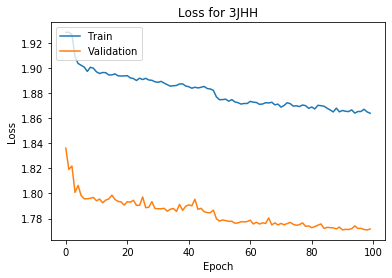

In [165]:
cv_predict=nn_model.predict(cv_input)
plot_history(history, mol_type)

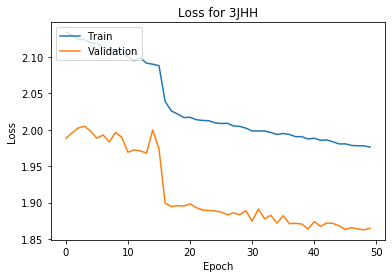

In [161]:
cv_predict=nn_model.predict(cv_input)
plot_history(history, mol_type)

In [166]:
accuracy=np.mean(np.abs(cv_target-cv_predict[0][:,0]))
print( accuracy,np.log(accuracy) )

0.14196192482823805 -1.9521963923479042


In [167]:
test_predict=nn_model.predict(test_input)

In [168]:
# Compare Prediction with a good CATBOOST prediction
blend35 = pd.read_csv('../submissions/BLEND035_sub_-2.00491CV.csv')
test = pd.read_csv('../input/test.csv')
blend35 = pd.concat([test, blend35], axis=1)

In [169]:
b35_3jhh = blend35.loc[blend35['type'] == '3JHH'].copy()

In [170]:
b35_3jhh['keras_preds'] = test_predict[0][:,0]

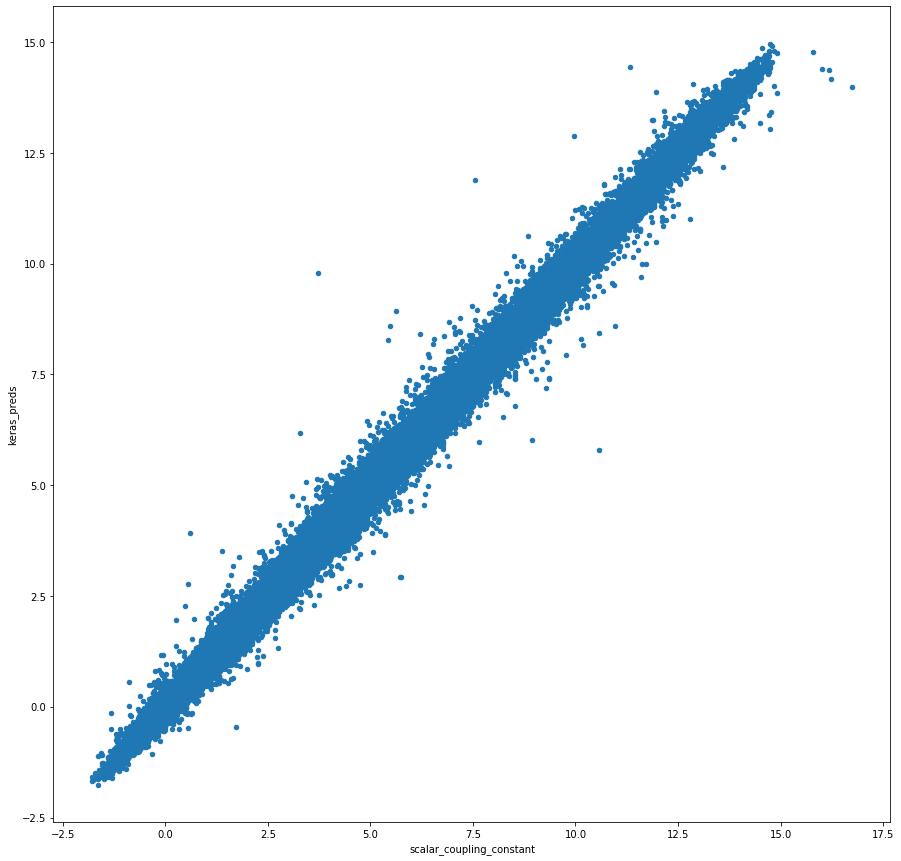

In [171]:
b35_3jhh.plot(x='scalar_coupling_constant', y='keras_preds', kind='scatter', figsize=(15, 15))
plt.show()

In [ ]:
cv_score.append(np.log(accuracy))
cv_score_total+=np.log(accuracy)

# Predict on the test data set using our trained model
test_predict=nn_model.predict(test_input)

# for each molecule type we'll grab the predicted values
# test_prediction[df_test["type"]==mol_type]=test_predict[0][:,0]
# K.clear_session()

# cv_score_total/=len(mol_types)